In [16]:
%matplotlib inline

import os
import time
import pickle
from multiprocessing import Pool as ThreadPool

import numpy as np

from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers

from tqdm import tqdm
from tqdm import tqdm_notebook

from sklearn.metrics import accuracy_score

np.random.seed(42)

# Custom imports
from lattice import Lattice
from get_lat_and_m import get_lattices_and_m

# Set plot params
plt.rc('font', size=14)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize

## ----------------------- CODE FROM PROJECT DESCRIPTION -----------------------


In [17]:
# Calculate critical temperature
Tc = 2 / np.log(1+np.sqrt(2))
print(f"Critical temperature: Tc = {Tc:.4f}")

Critical temperature: Tc = 2.2692


In [ ]:
# Use 6 threads to run some lattice evolutions
# With current parameters, this took a minute or two on an i7
# Dump out the lattice configurations/temperatures to a file
# and just load it if the file already exists, since this
# is a CPU intensive cell.

fname = "ising_config_data_big_and_m.pkl"

def get_lattices(T, N=10, Nlattices=25, Nthermal=200):
    """
    Generates a set of lattices at a given temperature
    
    Args:
        T (float): temperature of the lattice
        N (int): the lattice size
        Nlattices (int): the number of lattices to generate
        Nthermal (int): the number of steps to simulate thermalization
    """
    Ms = []
    m = np.abs()
    for _ in range(Nlattices):
        lat = Lattice(N=N,T=T)
        for _ in range(Nthermal):
            lat.step()
            Ms.append(lat.get_avg_magnetization())
        lattices.append(lat.lattice)
    m = np.abs(Ms.mean())
    return round(T, 4), round(m,4), lattices

if not os.path.exists(fname):
    print("Starting pool")
    pool = ThreadPool(6)
    Ts = np.arange(5.0,1.0,-0.1)
    d_data = {}
    print("Get pooling")
    for T, M, lattices in tqdm(pool.imap_unordered(get_lattices_and_m, Ts)):
        print(f'T={T}, m={m}')
        d_data[T] = {
            "lat":lattices,
            "mag": m
        }
    with open(fname,"wb") as fhout:
        pickle.dump(d_data,fhout)
    print(f">>> Dumped to {fname}")

else:
    d_data = pickle.load(open(fname,"rb"))
    print(">>> Loaded from {}".format(str(fname)))

In [5]:
# make vector of input matrices, vector of temperatures
X_data = []
y_data = []
T_data = []
m_data = []

for T, lat_data in d_data.items():
    configs = lat_data["lat"]
    m = lat_data["m"]
    for config in configs:
        # flip spins to double dataset keeping E same
        # this is also needed so ML algorithm doesn't learn
        # to prefer one magnetization sign over another
        # also make truth labels (0 is low T phase, 1 is high T phase)
        # and also mirror lattice horizontally/vertically to get free data
        target = 0
        if T > Tc:
            target = 1
            
        X_data.append(config)
        X_data.append(np.flip(config,0))
        X_data.append(np.flip(config,1))
        X_data.append(-config)
        X_data.append(-np.flip(config,0))
        X_data.append(-np.flip(config,1))
        
        for _ in range(6):
            T_data.append(T)
            m_data.append(m)
            y_data.append(target)


X_data = np.array(X_data)
y_data = np.array(y_data)
T_data = np.array(T_data)
m_data = np.array(m_data)

# convert spin matrices from -1,1 to 0,1
X_data = 0.5*(X_data+1)

# Thus, our training and test sets will consist of 
# the lattice images and the targets will be 0 or 1.
# If the lattice is at low (T<Tc) or high (T>Tc) temperature
# It's up to the NN / CNN to learn the concept of temperature/magnetization/etc.

TypeError: list indices must be integers or slices, not str

### Old code

In [7]:
# Use 6 threads to run some lattice evolutions
# With current parameters, this took a minute or two on an i7
# Dump out the lattice configurations/temperatures to a file
# and just load it if the file already exists, since this
# is a CPU intensive cell.

fname = "ising_config_data_big.pkl"

def get_lattices(T, N=10, Nlattices=25, Nthermal=200):
    """
    Generates a set of lattices at a given temperature
    
    Args:
        T (float): temperature of the lattice
        N (int): the lattice size
        Nlattices (int): the number of lattices to generate
        Nthermal (int): the number of steps to simulate thermalization
    """
    lattices = []
    for _ in range(Nlattices):
        lat = Lattice(N=N,T=T)
        for _ in range(Nthermal):
            lat.step()
        lattices.append(lat.lattice)
    return round(T, 4), lattices

if not os.path.exists(fname):
    pool = ThreadPool(6)
    Ts = np.arange(5.0,1.0, 0.1)
    d_data = {}
    for T, lattices in pool.imap_unordered(get_lattices, Ts):
        print(T)
        d_data[T] = lattices

    with open(fname,"wb") as fhout:
        pickle.dump(d_data,fhout)
    print(f">>> Dumped to {fname}")

else:
    d_data = pickle.load(open(fname,"rb"))
    print(">>> Loaded from {}".format(str(fname)))

>>> Loaded from ising_config_data_big.pkl


In [8]:
# make vector of input matrices, vector of temperatures
X_data = []
y_data = []
T_data = []

for T,configs in d_data.items():
    for config in configs:
        # flip spins to double dataset keeping E same
        # this is also needed so ML algorithm doesn't learn
        # to prefer one magnetization sign over another
        # also make truth labels (0 is low T phase, 1 is high T phase)
        # and also mirror lattice horizontally/vertically to get free data
        target = 0
        if T > Tc:
            target = 1
            
        X_data.append(config)
        X_data.append(np.flip(config,0))
        X_data.append(np.flip(config,1))
        X_data.append(-config)
        X_data.append(-np.flip(config,0))
        X_data.append(-np.flip(config,1))
        
        for _ in range(6):
            T_data.append(T)
            y_data.append(target)


X_data = np.array(X_data)
y_data = np.array(y_data)
T_data = np.array(T_data)

# convert spin matrices from -1,1 to 0,1
X_data = 0.5*(X_data+1)

# Thus, our training and test sets will consist of 
# the lattice images and the targets will be 0 or 1.
# If the lattice is at low (T<Tc) or high (T>Tc) temperature
# It's up to the NN / CNN to learn the concept of temperature/magnetization/etc.

In [9]:
# function to split the data
def split_data(X_data, y_data, T_data, Thi=4.7, Tlo=1.3, test_size=0,random_state=42):
    """
    Splits the data into train and test sets according to the settings.
    
    Either using sklearn train_test_split (test_size).  
    Or, alternatively, using T>Thi and T<Tlo data as training data and Tlo < T < Thi as predictions/test.
    """
    if test_size:
        print(f"Using sklearn to split data. Test size: {test_size*100:}%")
        X_train, X_test, y_train, y_test, T_train, T_test = \
          train_test_split(X_data, y_data, T_data, test_size=test_size, random_state=random_state)
    elif (Thi and Tlo):
        print(f"Using T>{Thi} and T<{Tlo} as training data.")
        train_set = np.logical_or(T_data>=Thi,T_data<=Tlo)
        test_set = np.logical_not(train_set)
        X_train = X_data[train_set]
        X_test = X_data[test_set]
        y_train = y_data[train_set]
        y_test = y_data[test_set]
        T_train = T_data[train_set]
        T_test = T_data[test_set]
    else:
        print("No rule to split data.")
        return None
        
    print(f"...Training samples: {X_train.shape[0]}")
    print(f"...Testing samples:  {X_test.shape[0]}")
    return(X_train, X_test, y_train, y_test, T_train, T_test)

## ----------------- END OF CODE FROM PROJECT DESCRIPTION -----------------

## Task 2: NN with 3 neurons in the hidden layer.

### Load the data 

In [10]:
X_train, X_test, y_train, y_test, T_train, T_test = split_data(X_data, y_data, T_data,test_size=0.3)

Using sklearn to split data. Test size: 30.0%
...Training samples: 4200
...Testing samples:  1800


In [11]:
# Only interested in the magnetization data
#m_train = X_train[:,2]
#m_test = X_test[:,2]

# Make the data symmetric - encode +-1 instead 0 and 1. 
m_train = np.where(X_train==0, -1,  X_train)
m_test = np.where(X_test==0, -1,  X_test)

# Expand dimensions to len, 1 ,1
#m_train =  np.expand_dims(m_train, 2)
#m_test =  np.expand_dims(m_test, 2)

# One-hot encode targets
y_train = keras.utils.to_categorical(y_train, 2)
y_test = keras.utils.to_categorical(y_test, 2)

print(m_train)

# Flatten input data
#m_train = m_train.flatten()
#m_test = m_test.flatten()

[[[ 1.  1.  1. ...  1.  1. -1.]
  [ 1.  1.  1. ...  1.  1.  1.]
  [ 1.  1.  1. ...  1.  1.  1.]
  ...
  [ 1.  1.  1. ...  1.  1.  1.]
  [ 1.  1.  1. ...  1.  1.  1.]
  [ 1.  1.  1. ...  1. -1.  1.]]

 [[ 1. -1.  1. ...  1.  1.  1.]
  [ 1. -1. -1. ...  1.  1.  1.]
  [-1. -1. -1. ... -1. -1. -1.]
  ...
  [-1.  1.  1. ... -1. -1. -1.]
  [-1.  1.  1. ... -1. -1. -1.]
  [ 1. -1.  1. ...  1.  1. -1.]]

 [[ 1. -1. -1. ...  1.  1.  1.]
  [ 1.  1.  1. ... -1.  1.  1.]
  [-1.  1.  1. ...  1.  1.  1.]
  ...
  [-1.  1. -1. ...  1.  1.  1.]
  [ 1.  1. -1. ...  1.  1. -1.]
  [ 1.  1.  1. ...  1.  1.  1.]]

 ...

 [[-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  ...
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]
  [-1. -1. -1. ... -1. -1. -1.]]

 [[ 1.  1.  1. ...  1.  1.  1.]
  [ 1.  1.  1. ...  1.  1.  1.]
  [ 1.  1.  1. ...  1.  1.  1.]
  ...
  [ 1.  1.  1. ... -1.  1.  1.]
  [ 1.  1.  1. ... -1.  1.  1.]
  [ 1.  1.  1. ...  1.  1.  

### Define the DNN

### Train and predict

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 303       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 8         
Total params: 311
Trainable params: 311
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.


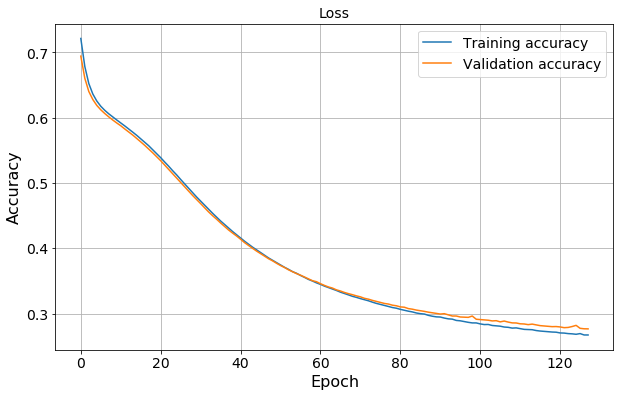

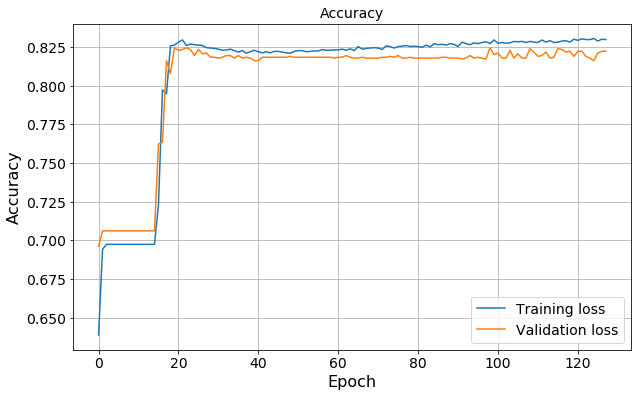

In [12]:
def create_dnn(data, n_neurons=3):
    '''
    Create a DNN using the shape of the data tensor and n_neurons number of neurons in the hidden
    layer, with an L2 regularizer to minimize overfitting. Only take in the magnetization as input data.
    '''
    model = Sequential()
    model.add(Flatten(input_shape=(data.shape[1], data.shape[2])))  # Flatten the 10x10 grid
    hidden_layer = Dense(n_neurons,
                    activation='sigmoid',
                    kernel_regularizer=regularizers.l2(0.01),
                    activity_regularizer=regularizers.l1(0.01))
    model.add(hidden_layer)
    model.add(Dense(2, activation='sigmoid'))
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model, hidden_layer

dnn, hidden_layer = create_dnn(m_train, 3)
dnn.summary()

# Fit on X_train and y_train
epochs = 64
hist = dnn.fit(x=m_train, 
               y=y_train,
               validation_data=(m_test, y_test),
               epochs=128,
               batch_size=64,
               verbose=0)

# Plot training and test performance
fig1, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(hist.history['loss'], label='Training accuracy')
ax1.plot(hist.history['val_loss'], label='Validation accuracy')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.set_title("Loss")
ax1.grid()
ax1.legend(loc='best')

fig2, ax2 = plt.subplots(figsize=(10,6))
ax2.plot(hist.history['acc'], label='Training loss')
ax2.plot(hist.history['val_acc'], label='Validation loss')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_title("Accuracy")
ax2.grid()
ax2.legend(loc='best')

In [14]:
# Get the weights and plot the intermediate results
W = hidden_layer.get_weights()[0]
b = hidden_layer.get_weights()[1]
print(W.shape)
print(b.shape)

# Generate input data for different magnetizations m. 


(100, 3)
(3,)


## Konstigt här nedanför

In [ ]:
def calc_accuracy(p, t):
    '''Calculates the accuracy for prediction p compared to targets t.'''
    nbr_correct = np.sum(np.around(p) == t)
    return nbr_correct/len(p)

# Test calc_accuracy
p_test = [0.6, 0.4, 0.05, 1]
t_test = [1, 1, 1, 1]
print(f'calc_accuracy passes unit tests: {0.5 == calc_accuracy(p_test, t_test)}')
    

def sigmoid(a):
    '''¨Returns the sigmoid value of the activation a.'''
    return 1/(1+np.exp(-a))


def feed_forward(x, w, b):
    '''Performs the feed-forward pass for our neuron. Return the activation.'''
    z = x@w + b.T
    return sigmoid(z)  
   

def cost_function(y, t, b_w, alpha):
    '''
    Calculates the cost-function for output data y and labels t. 
    Also utilizes weight regularization.
    '''
    cost = - np.sum( t*np.log(y) + (1-t)*np.log(1-y) )
    reg = 1/2 * np.sum(b_w**2)
    return cost + alpha*reg
    
    
def train_neuron(m_train, t_train, m_test, t_test, n_neurons, epochs=1000, batch_size=50, alpha=1, eta=0.01, seed=1):
    '''
    Trains the simple DNN. Only take in m data.
    Randomize weights and bias term. Use batch gradient descent.
    '''
    # Set the seed
    np.random.seed(seed)
    # Randomize the weights
    W = 100*np.random.uniform(size=(1, n_neurons)) 
    b = 100*np.random.uniform(size=(1, n_neurons))
    # Iterate over all instances of data
    costs = []
    train_accuracies = []
    test_accuracies = []
    for epoch in tqdm_notebook(range(epochs)):
        # Train the network in epochs - one epoch goes through all the data
        # Shuffle the x and t vectors at the beginning of each epoch
        shuffle_idx = np.random.randint(0, len(m_train)-1, len(m_train))
        m_train = m_train[shuffle_idx]
        t_train = y_train[shuffle_idx]
        
        # Split into batches of equal size
        m_batches = np.array_split(m_train, batch_size)
        t_batches = np.array_split(t_train, batch_size)
        for idx, m_b in enumerate(m_batches):
            m_b = np.expand_dims(m_b, -1)
            t_b = t_batches[idx]
            
            # Create design matrix
            M = np.concatenate((m_b[:,0]**0, m_b[:,0], m_b[:,1]), axis=1)
            
            # Squeeze x_i to remove unnecessary dimension
            m_b = np.squeeze(m_b)
            
            # Calculate the network output
            y_b = feed_forward(m_b, W, b)
            
            # Create vector of bias and weights
            bias_and_weights = np.concatenate((b, W), axis=0)  # [b, w]
            
            # Calculate the cost and do a prediction - for monitoring training
            c_b = cost_function(y_b, t_b, bias_and_weights, alpha)
            costs.append(c_b)
            
            # Update to our weights - last term is from regularizer
            delta_bias_and_weights = (M.T).dot(t_b-y_b) - alpha*bias_and_weights
            
            # Update weights and biases
            b += eta*delta_bias_and_weights[:,0]
            W += eta*delta_bias_and_weights[:,1:]
            
        # Do a predict on train data set, for monitoring training.
        train_acc = calc_accuracy(feed_forward(m_train, W, b), t_train)
        train_accuracies.append(train_acc)
        test_acc = calc_accuracy(feed_forward(m_test, W, b), t_test)
        test_accuracies.append(test_acc)
        # TODO add losses?
    print(f'Final test accuracy was: {test_acc:.3f}')
    fig1, ax1 = plt.subplots(figsize=(10,6))
    ax1.plot(np.log(costs))
    ax1.set_ylabel(r'log(cost)')
    ax1.set_xlabel(r'Iterations')
    ax1.grid()
    
    fig2, ax2 = plt.subplots(figsize=(10,6))
    ax2.plot(train_accuracies, label='Training accuracy')
    ax2.plot(test_accuracies, label='Test accuracy')
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.legend(loc='best')
    ax2.grid()
    # Return the optimized weights
    return w, b
    

w_star, b_star = train_neuron(m_train, y_train, m_test, y_test, 3)